In [23]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# How many seconds to run each step for. This should be long enough for stability to be observed.
step_duration_s = 20
# The step amplitudes in nA. Each amplitude will be run for step_duration
start_amp = 0.5
peak_amp = 1.5
amp_delta = 0.1
step_amplitudes_nA = np.concatenate((np.arange(start_amp, peak_amp, amp_delta), \
                                     np.arange(peak_amp, start_amp-amp_delta/2, -amp_delta)), axis=None)

neurons_to_stimulate = ["AWAR"]

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)

# If set, also plot the unnormalized V (w.r.t changing Vth). Caching is currently NOT implemented for this. 
plot_unnormalized_v = True

In [24]:
# Setup the model
from model.neural_model import NeuralModel
from util.plot_util import *
import os
import pickle

neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AWA"
])
model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

# Set I_inj_i(t)

def time_to_I_ext_fun(t):
  amp = step_amplitudes_nA[int(t / step_duration_s)]
  cur_I_ext = np.zeros(N)
  for neuron in neurons_to_stimulate:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    cur_I_ext[neuron_id] = amp
  return cur_I_ext

# These are timesteps when I_ext changes
num_step_values = len(step_amplitudes_nA)
t_changes_I_ext = np.array(range(num_step_values)) * step_duration_s
t_changes_I_ext = t_changes_I_ext.tolist()
model.set_I_ext(time_to_I_ext_fun, t_changes_I_ext)

model.init_kunert_2017()

step_duration_timesteps = int(step_duration_s / model.dt)
simul_timesteps = step_duration_timesteps * len(step_amplitudes_nA)

In [25]:
# Run the model. Or not, if cached result already exists
# Cache file is about ~1MB for 1 second.
cache_key = "%d_%.2f_%.2f_%.2f_%s" % \
  (step_duration_s, start_amp, peak_amp, amp_delta, "_".join(neurons_to_stimulate))
cache_path = "../local_results/exp_CHANGING_STEP_AWA/" + cache_key

v_normalized_mat = []
if os.path.isfile(cache_path) and not plot_unnormalized_v:
  print("Loading saved results from pickle file {}".format(cache_path))
  with open(cache_path, "rb") as f:
    v_normalized_mat = pickle.load(f)
else:
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_timesteps)
  # Update cache
  with open(cache_path, "wb") as f:
    pickle.dump(v_normalized_mat, f)

Timestep 0 out of 42000
Timestep 100 out of 42000
Timestep 200 out of 42000
Timestep 300 out of 42000
Timestep 400 out of 42000
Timestep 500 out of 42000
Timestep 600 out of 42000
Timestep 700 out of 42000
Timestep 800 out of 42000
Timestep 900 out of 42000
Timestep 1000 out of 42000
Timestep 1100 out of 42000
Timestep 1200 out of 42000
Timestep 1300 out of 42000
Timestep 1400 out of 42000
Timestep 1500 out of 42000
Timestep 1600 out of 42000
Timestep 1700 out of 42000
Timestep 1800 out of 42000
Timestep 1900 out of 42000
Timestep 2000 out of 42000
Timestep 2100 out of 42000
Timestep 2200 out of 42000
Timestep 2300 out of 42000
Timestep 2400 out of 42000
Timestep 2500 out of 42000
Timestep 2600 out of 42000
Timestep 2700 out of 42000
Timestep 2800 out of 42000
Timestep 2900 out of 42000
Timestep 3000 out of 42000
Timestep 3100 out of 42000
Timestep 3200 out of 42000
Timestep 3300 out of 42000
Timestep 3400 out of 42000
Timestep 3500 out of 42000
Timestep 3600 out of 42000
Timestep 3700

Timestep 29800 out of 42000
Timestep 29900 out of 42000
Timestep 30000 out of 42000
Timestep 30100 out of 42000
Timestep 30200 out of 42000
Timestep 30300 out of 42000
Timestep 30400 out of 42000
Timestep 30500 out of 42000
Timestep 30600 out of 42000
Timestep 30700 out of 42000
Timestep 30800 out of 42000
Timestep 30900 out of 42000
Timestep 31000 out of 42000
Timestep 31100 out of 42000
Timestep 31200 out of 42000
Timestep 31300 out of 42000
Timestep 31400 out of 42000
Timestep 31500 out of 42000
Timestep 31600 out of 42000
Timestep 31700 out of 42000
Timestep 31800 out of 42000
Timestep 31900 out of 42000
Timestep 32000 out of 42000
Timestep 32100 out of 42000
Timestep 32200 out of 42000
Timestep 32300 out of 42000
Timestep 32400 out of 42000
Timestep 32500 out of 42000
Timestep 32600 out of 42000
Timestep 32700 out of 42000
Timestep 32800 out of 42000
Timestep 32900 out of 42000
Timestep 33000 out of 42000
Timestep 33100 out of 42000
Timestep 33200 out of 42000
Timestep 33300 out o

# Plot stimulus

<IPython.core.display.Javascript object>


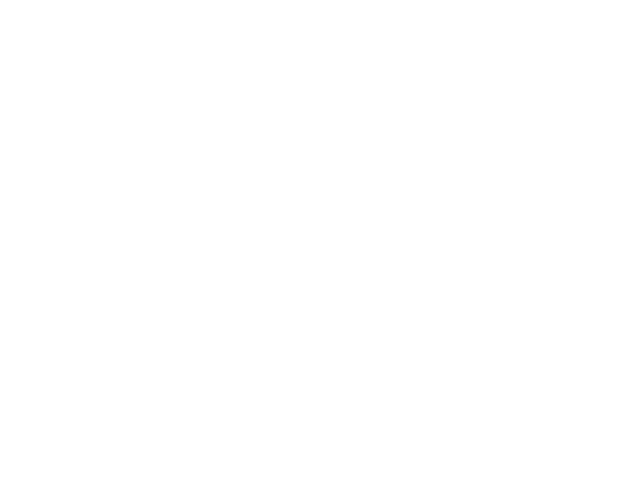

In [26]:
times = np.array(np.arange(0, simul_timesteps * model.dt, model.dt))

awal_index = neuron_metadata_collection.get_id_from_name("AWAL")
amps = [time_to_I_ext_fun(time)[awal_index] for time in times]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, amps)
ax.set_title("Stimulus graph")
ax.set_ylabel("Injected current to AWAL, AWAR(nA)")
ax.set_xlabel("Time (s)")
_ = _

# Plot potentials of selected neurons

<IPython.core.display.Javascript object>


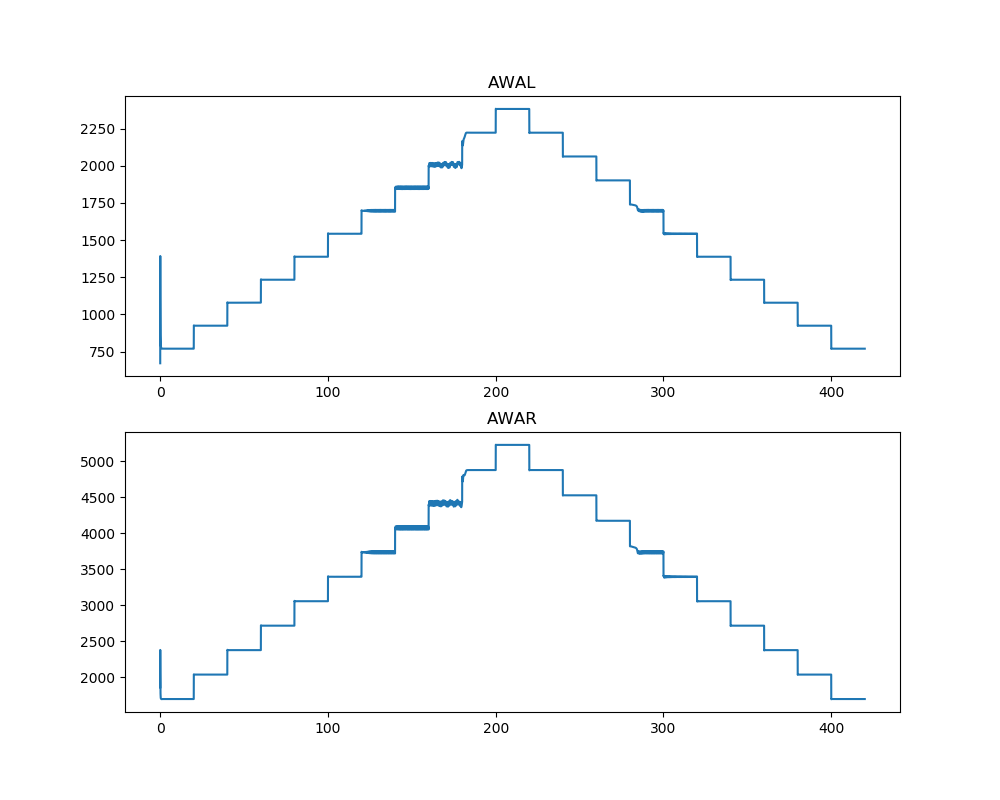

In [32]:
if plot_unnormalized_v:
  fig = plot_potentials(neurons_to_observe, v_mat, model.dt, neuron_metadata_collection)
  fig.show()

<IPython.core.display.Javascript object>


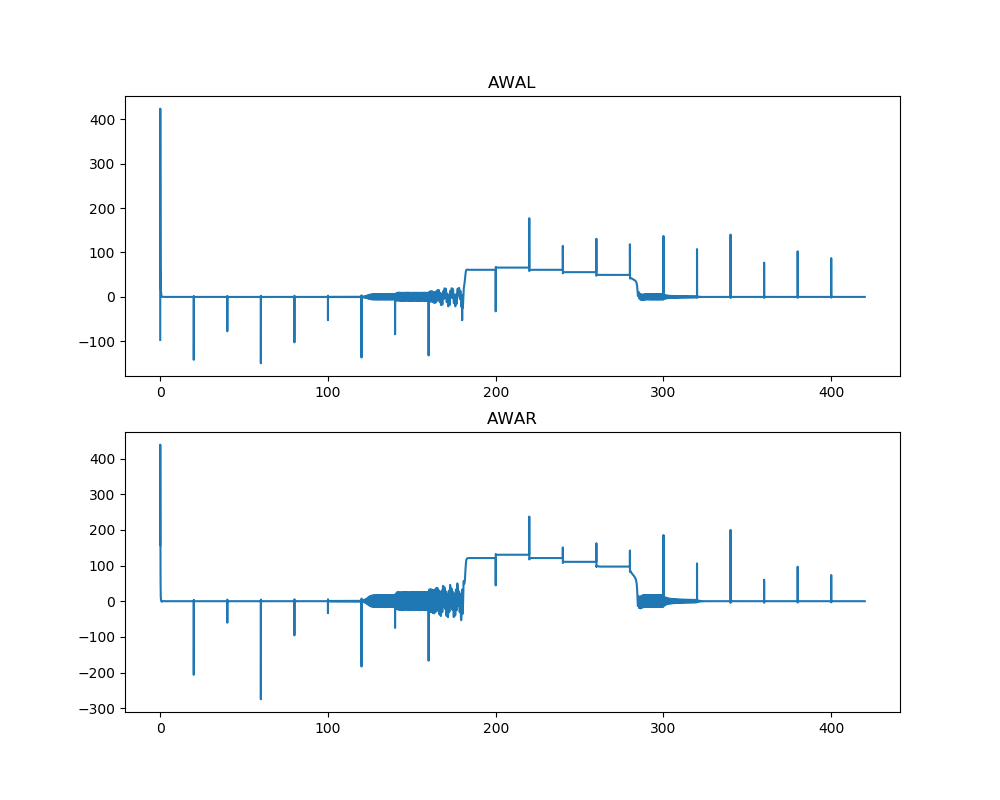

In [28]:
%matplotlib notebook
fig = plot_potentials(neurons_to_observe, v_normalized_mat, model.dt, neuron_metadata_collection)
fig.show()

# Plot summarized dynamics per neuron class

<IPython.core.display.Javascript object>


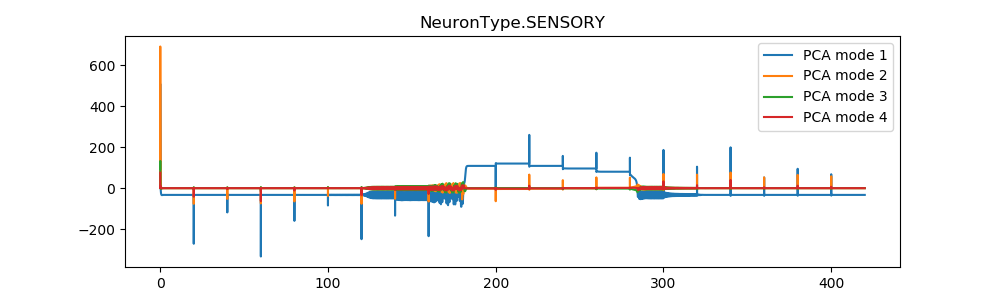

<IPython.core.display.Javascript object>


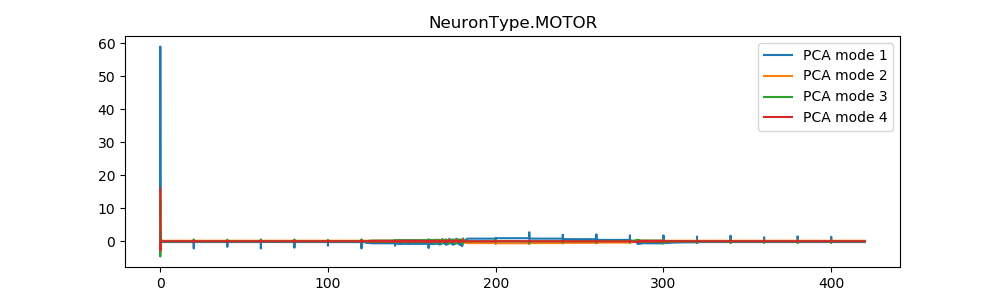

<IPython.core.display.Javascript object>


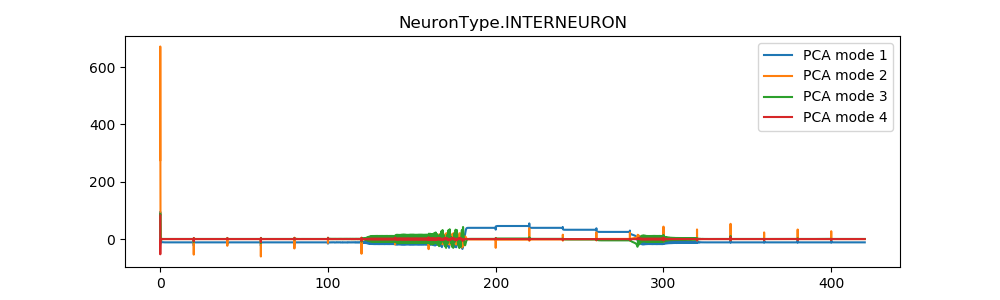

In [29]:
plot_pcas(v_normalized_mat, model.dt, neuron_metadata_collection)

# Bifurcation plot

In [30]:
import util.numpy_util as np_util

# From neuron name to a list of summary statistics of one step of one neuron.
# Each array element is (prev_I, now_I, minV, maxV, meanV)
step_results_per_neuron = {}

for step_amp_i in range(len(step_amplitudes_nA)):
  prev_step_amp_nA = None
  if step_amp_i > 0:
    prev_step_amp_nA = step_amplitudes_nA[step_amp_i-1]
  step_amp_nA = step_amplitudes_nA[step_amp_i]
  timestep_start = int(step_amp_i * step_duration_s / model.dt)
  timestep_end = step_duration_timesteps + timestep_start - 1
  timestep_stable = int(timestep_end - step_duration_timesteps * 0.2)
  stable_traces_for_step = v_normalized_mat[timestep_stable:timestep_end,:]
  for neuron in neurons_to_observe:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    stable_traces_for_neuron = stable_traces_for_step[:, neuron_id]
    minV = min(stable_traces_for_neuron)
    maxV = max(stable_traces_for_neuron)
    meanV = np.mean(stable_traces_for_neuron)
    
    if neuron not in step_results_per_neuron:
      step_results_per_neuron[neuron] = []
    step_results_per_neuron[neuron].append((prev_step_amp_nA, step_amp_nA, minV, maxV, meanV))

# Ascending unique current amplitudes in Na
current_Nas = np.arange(start_amp, peak_amp+amp_delta/2, amp_delta)
# Key = neuron, value = list of statistics, aligned to current_Nas
minVs_per_neuron_asc = {}
maxVs_per_neuron_asc = {}
meanVs_per_neuron_asc = {}
minVs_per_neuron_desc = {}
maxVs_per_neuron_desc = {}
meanVs_per_neuron_desc = {}

for neuron in neurons_to_observe:
  for neuron_to_stats in [minVs_per_neuron_asc, maxVs_per_neuron_asc, meanVs_per_neuron_asc, \
                         minVs_per_neuron_desc, maxVs_per_neuron_desc, meanVs_per_neuron_desc]:
    neuron_to_stats[neuron] = [None] * len(current_Nas)

for neuron in neurons_to_observe:
  # Each array element is (prev_I, now_I, minV, maxV, avgV)
  step_results = step_results_per_neuron[neuron]
  for (prev_I, now_I, minV, maxV, meanV) in step_results:
    min_Vs = minVs_per_neuron_desc[neuron]
    max_Vs = maxVs_per_neuron_desc[neuron]
    mean_Vs = meanVs_per_neuron_desc[neuron]
    if prev_I is None or now_I > prev_I:
      # Ascending case.
      min_Vs = minVs_per_neuron_asc[neuron]
      max_Vs = maxVs_per_neuron_asc[neuron]
      mean_Vs = meanVs_per_neuron_asc[neuron]
    current_Na_aligned_i = np_util.find_nearest_idx(current_Nas, now_I)
    min_Vs[current_Na_aligned_i] = minV
    max_Vs[current_Na_aligned_i] = maxV
    mean_Vs[current_Na_aligned_i] = meanV
  

<IPython.core.display.Javascript object>


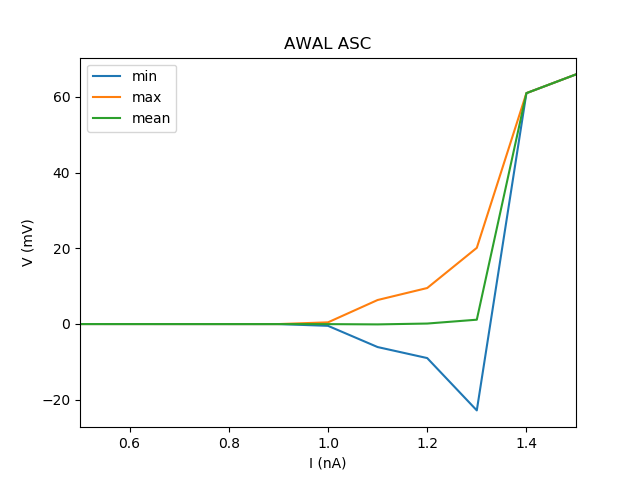

<IPython.core.display.Javascript object>


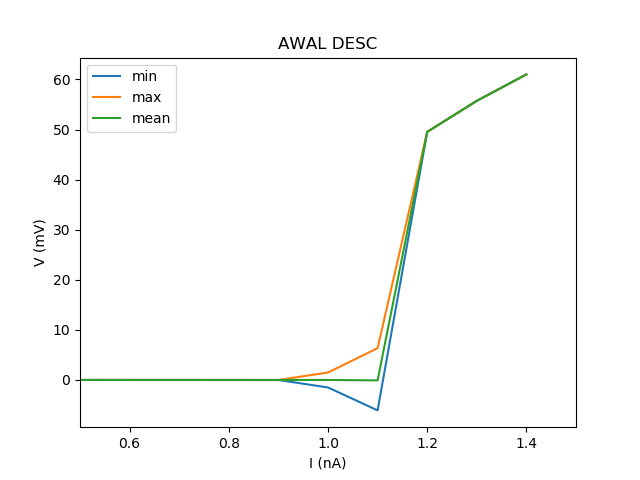

<IPython.core.display.Javascript object>


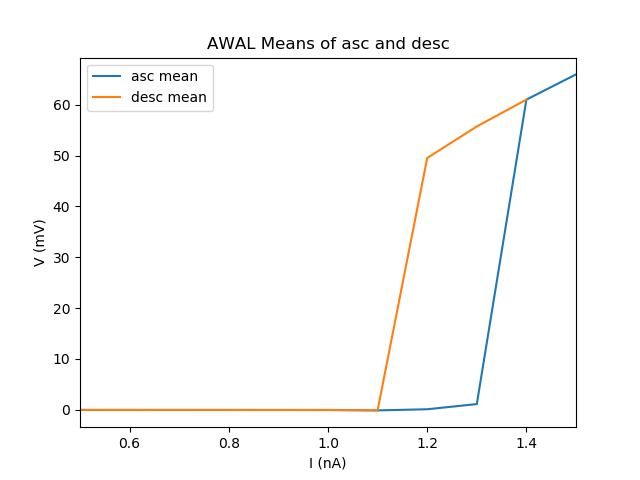

<IPython.core.display.Javascript object>


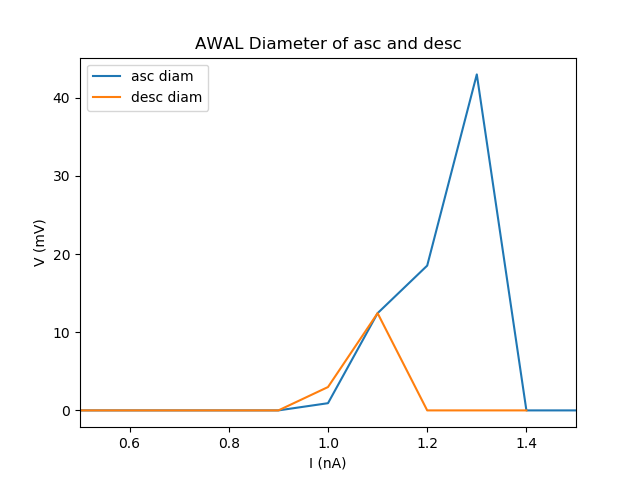

<IPython.core.display.Javascript object>


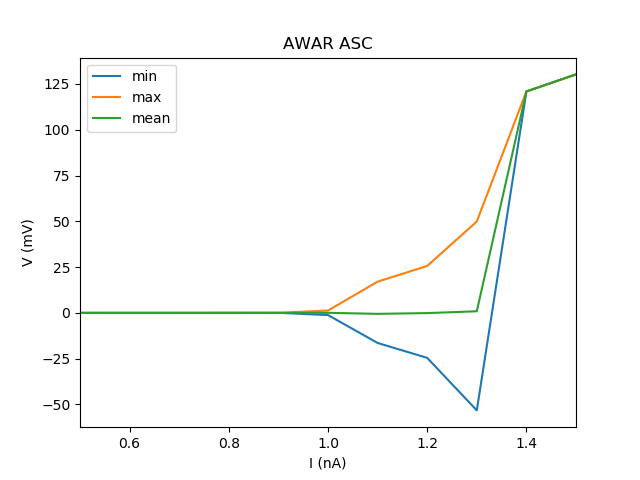

<IPython.core.display.Javascript object>


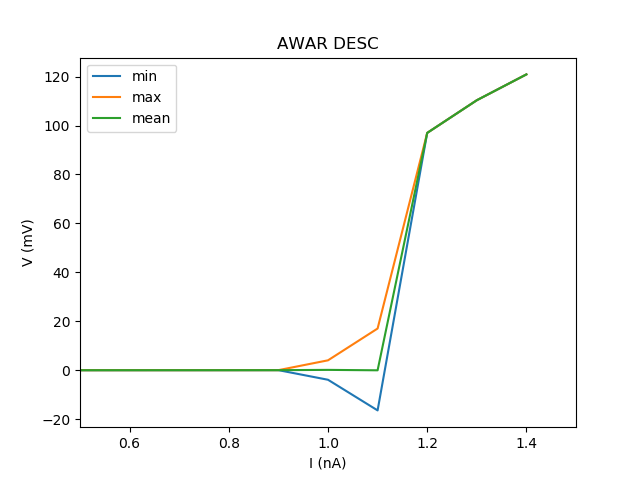

<IPython.core.display.Javascript object>


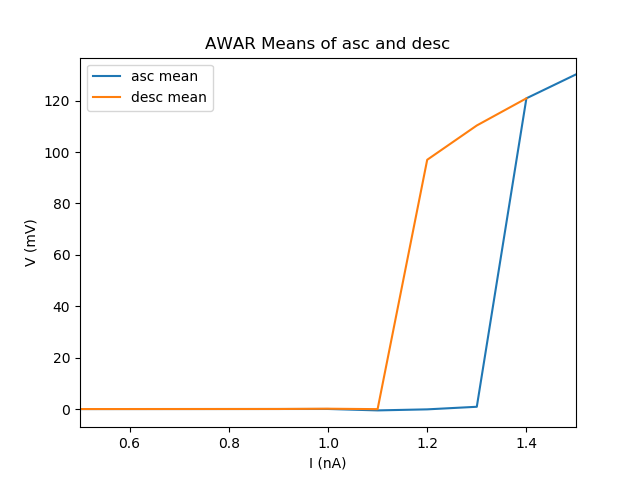

<IPython.core.display.Javascript object>


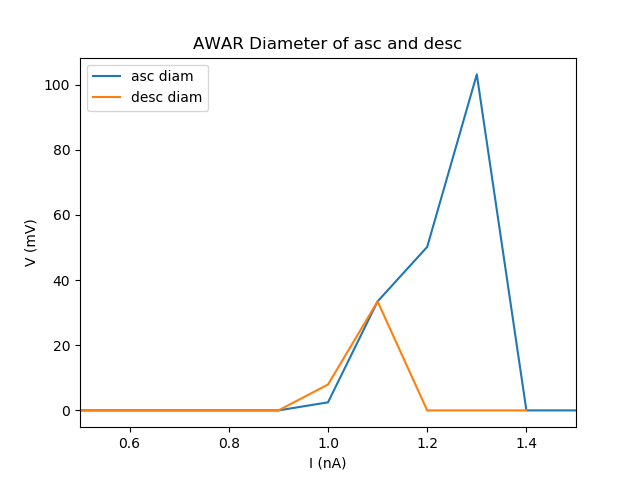

In [31]:
# Plot the summary statistics per neuron
for neuron in neurons_to_observe:
  minVs_per_neuron_asc[neuron]
  maxVs_per_neuron_asc[neuron]
  meanVs_per_neuron_asc[neuron]
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(current_Nas, minVs_per_neuron_asc[neuron], label="min")
  ax.plot(current_Nas, maxVs_per_neuron_asc[neuron], label="max")
  ax.plot(current_Nas, meanVs_per_neuron_asc[neuron], label="mean")
  ax.set_title("%s ASC" % neuron)
  ax.set_xlim(min(current_Nas), max(current_Nas))
  ax.set_ylabel("V (mV)")
  ax.set_xlabel("I (nA)")
  ax.legend()
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(current_Nas, minVs_per_neuron_desc[neuron], label="min")
  ax.plot(current_Nas, maxVs_per_neuron_desc[neuron], label="max")
  ax.plot(current_Nas, meanVs_per_neuron_desc[neuron], label="mean")
  ax.set_title("%s DESC" % neuron)
  ax.set_xlim(min(current_Nas), max(current_Nas))
  ax.set_ylabel("V (mV)")
  ax.set_xlabel("I (nA)")
  ax.legend()
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(current_Nas, meanVs_per_neuron_asc[neuron], label="asc mean")
  ax.plot(current_Nas, meanVs_per_neuron_desc[neuron], label="desc mean")
  ax.set_title("%s Means of asc and desc" % neuron)
  ax.set_xlim(min(current_Nas), max(current_Nas))
  ax.set_ylabel("V (mV)")
  ax.set_xlabel("I (nA)")
  ax.legend()
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  asc_diams = np.array(maxVs_per_neuron_asc[neuron]) - np.array(minVs_per_neuron_asc[neuron])
  # Desc has one entry less than asc, need to remove the last index, which contains None
  desc_diams = np.array(maxVs_per_neuron_desc[neuron][:-1]) - np.array(minVs_per_neuron_desc[neuron][:-1])
  ax.plot(current_Nas, asc_diams, label="asc diam")
  ax.plot(current_Nas[:-1], desc_diams, label="desc diam")
  ax.set_title("%s Diameter of asc and desc" % neuron)
  ax.set_xlim(min(current_Nas), max(current_Nas))
  ax.set_ylabel("V (mV)")
  ax.set_xlabel("I (nA)")
  ax.legend()